In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model, Sequential, load_model

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras_radam import RAdam

warnings.filterwarnings('ignore')
%matplotlib inline

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Dot Product with RMSE loss function

In [2]:
from helpers import load_data

DATA_TRAIN_PATH = "data/data_train.csv"
ratings = load_data(DATA_TRAIN_PATH)

DATA_TEST_PATH = "data/sampleSubmission.csv"
samples = load_data(DATA_TEST_PATH)

In [3]:
samples.head()

,user_id,movie_id,rating
0,37,1,3
1,73,1,3
2,156,1,3
3,160,1,3
4,248,1,3


In [4]:
n_users = len(ratings.user_id.unique())
n_movies = len(ratings.movie_id.unique())

In [12]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.2, random_state=1)

In [10]:
train = ratings.copy()
train.head()

,user_id,movie_id,rating
0,44,1,4
1,61,1,3
2,67,1,4
3,72,1,3
4,86,1,5


In [7]:
from keras import losses
from keras.utils import to_categorical
from keras import backend
from keras.regularizers import l2

K = 25;

#creating movie embedding path
movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(n_movies+1, K, name="Movie-Embedding", embeddings_regularizer=l2(1e-6))(movie_input)
movie_vec = Flatten(name="Flatten-Movies")(movie_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, K, name="User-Embedding", embeddings_regularizer=l2(1e-6))(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# performing dot product and creating model
prod = Dot(name="Dot-Product", axes=1)([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['mse', 'accuracy'])

# Optimizer : 'sgd', adam', RAdam(), 
# Loss = 'mean_squared_error'


Epoch 1/20
1176952/1176952 [==============================] - 10s 9us/step - loss: 14.6890 - mse: 14.6879 - accuracy: 0.0036
Epoch 2/20
1176952/1176952 [==============================] - 10s 9us/step - loss: 4.4862 - mse: 4.4751 - accuracy: 0.1524
Epoch 3/20
1176952/1176952 [==============================] - 11s 9us/step - loss: 1.4123 - mse: 1.3936 - accuracy: 0.3337
Epoch 4/20
1176952/1176952 [==============================] - 11s 9us/step - loss: 1.1096 - mse: 1.0886 - accuracy: 0.3596
Epoch 5/20
1176952/1176952 [==============================] - 11s 9us/step - loss: 1.0474 - mse: 1.0255 - accuracy: 0.3621
Epoch 6/20
1176952/1176952 [==============================] - 11s 9us/step - loss: 1.0281 - mse: 1.0056 - accuracy: 0.3634
Epoch 7/20
1176952/1176952 [==============================] - 11s 9us/step - loss: 1.0199 - mse: 0.9973 - accuracy: 0.3642
Epoch 8/20
1176952/1176952 [==============================] - 11s 9us/step - loss: 1.0152 - mse: 0.9924 - accuracy: 0.3646
Epoch 9/20
11

Text(0, 0.5, 'Training Error')

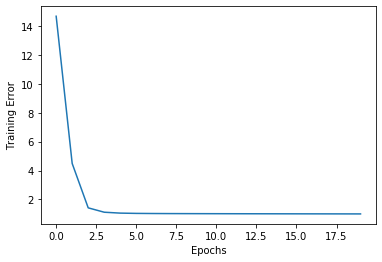

In [11]:
history = model.fit([train.user_id, train.movie_id], train.rating, batch_size=1000, epochs=20, verbose=1) #, validation_data=([test.user_id, test.movie_id], test.rating))
# model.save('regression_model.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [12]:
model.evaluate([test.user_id, test.movie_id], test.rating)

 481088/1176952 [===========>..................] - ETA: 19s

KeyboardInterrupt: 

In [32]:
pred_test = model.predict([test.user_id, test.movie_id])

In [33]:
for i in range(pred_test.shape[0]):
#     pred[i] = np.round(pred[i])
    if (pred_test[i] < 1):
        pred_test[i] = 1
    elif (pred_test[i] > 5):
        pred_test[i] = 5

In [34]:
test['MF_RMSE_rating'] = pred_test
test

,user_id,movie_id,rating,MF_RMSE_rating
1014743,1219,803,5,3.669779
791571,1865,643,1,4.279624
967641,1382,771,3,3.110157
65567,3295,53,3,3.705725
622228,9259,530,4,4.126890
...,...,...,...,...
468443,2110,403,5,3.829343
1064490,9211,855,2,3.105712
1172922,7228,996,3,3.520793
327551,9827,272,5,3.808119


In [13]:
pred = model.predict([samples.user_id, samples.movie_id])

In [14]:
pred = np.asarray(pred)

In [ ]:
for i in range(pred.shape[0]):
#     pred[i] = np.round(pred[i])
    if (pred[i] < 1):
        pred[i] = 1
    elif (pred[i] > 5):
        pred[i] = 5

In [ ]:
submission = load_data(DATA_TEST_PATH)
submission['MF_RMSE_rating'] = pred
submission

In [41]:
from helpers import create_csv

DATA_SUBMISSION = "data/MF_RMSE_test.csv" 
submission.to_csv(DATA_SUBMISSION)

DATA_SUBMISSION2 = "data/MF_RMSE_submission.csv"
test.to_csv(DATA_SUBMISSION2)

Dot Product with RMSE using librairies : pandas and keras - AICrowd : RMSE = 1.039 ; Secondary = 0.136

The score stays the same when we increase 'epoch' or 'K'.

# Dot Product with Cross validation

In [ ]:
n_split=3

X = ratings[['user', 'movie']].values
y = ratings['rating']

if os.path.exists('regression_model.h5'):
    model = load_model('regression_model.h5')
else:
    for train_index, test_index in KFold(n_split).split(X):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
  
        model=create_model()
        history = model.fit(x_train, y_train, batch_size=1000, epochs=20, verbose=1)
    
    history = model.fit([train.user_id, train.movie_id], train.rating, )
    model.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")
    
    
  
    print('Model evaluation ',model.evaluate(x_test,y_test))